# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.55$, $\alpha=2$) ($\tau$ slightly high)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau = 1.55
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

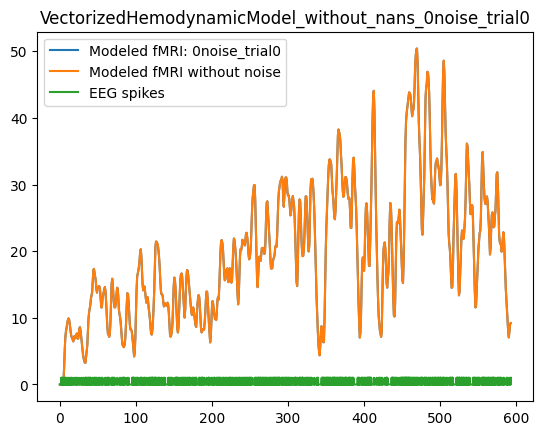

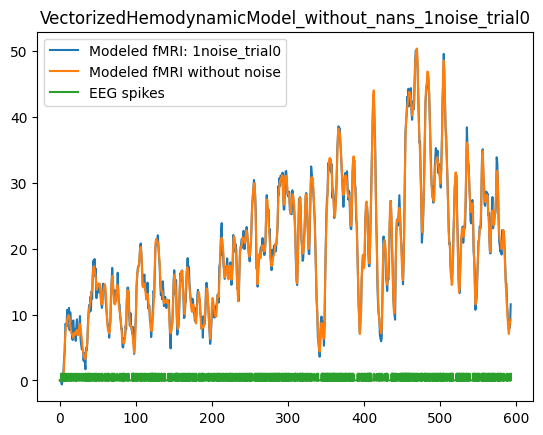

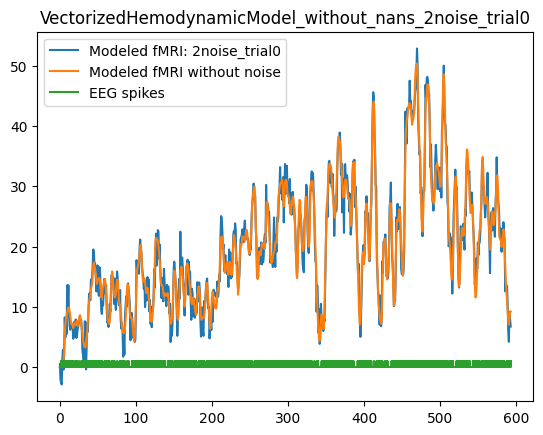

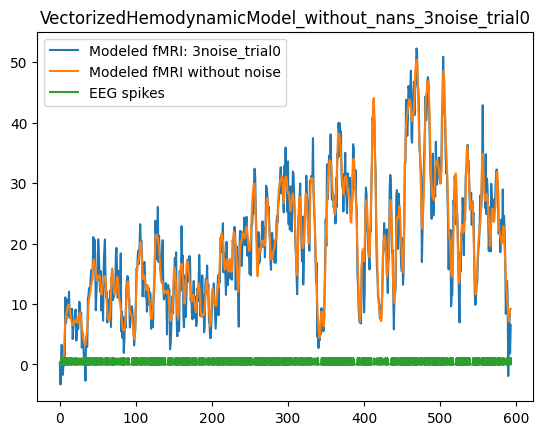

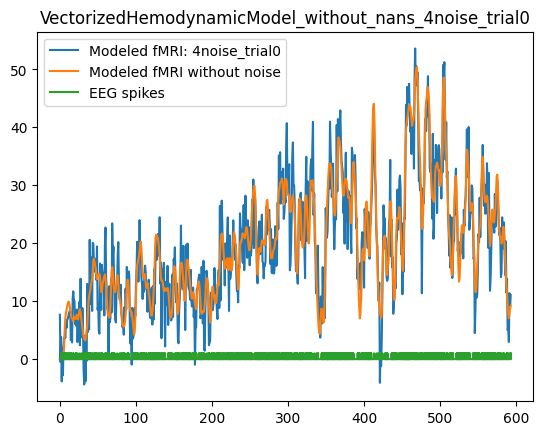

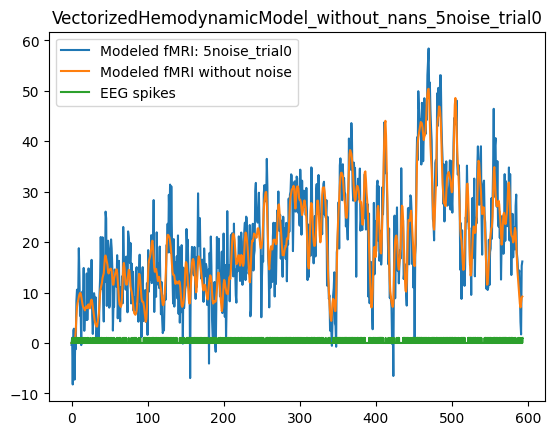

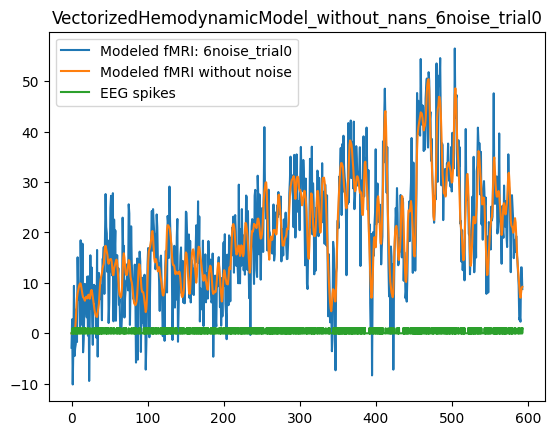

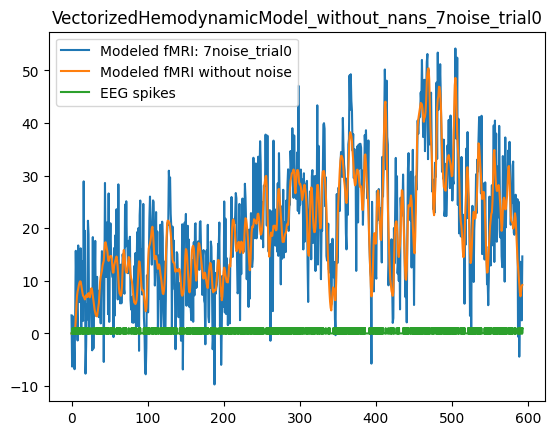

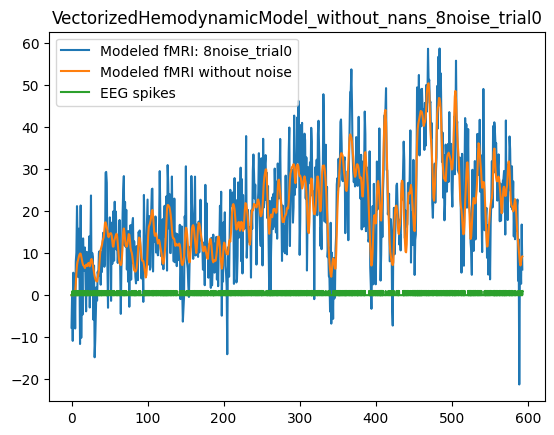

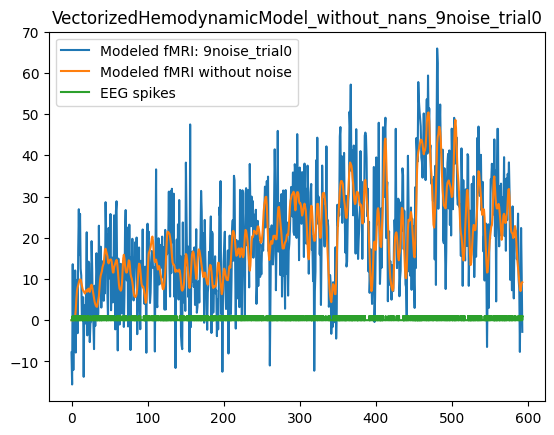

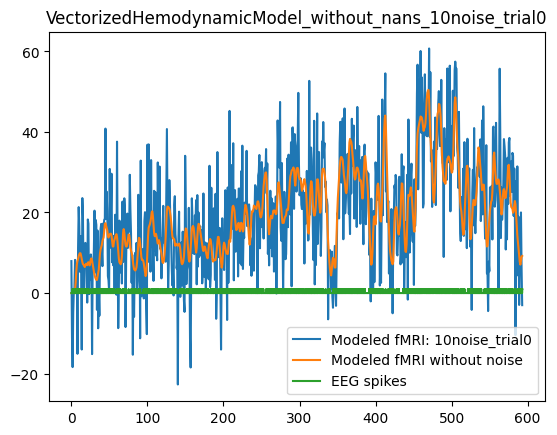

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.55, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.55, alpha=2


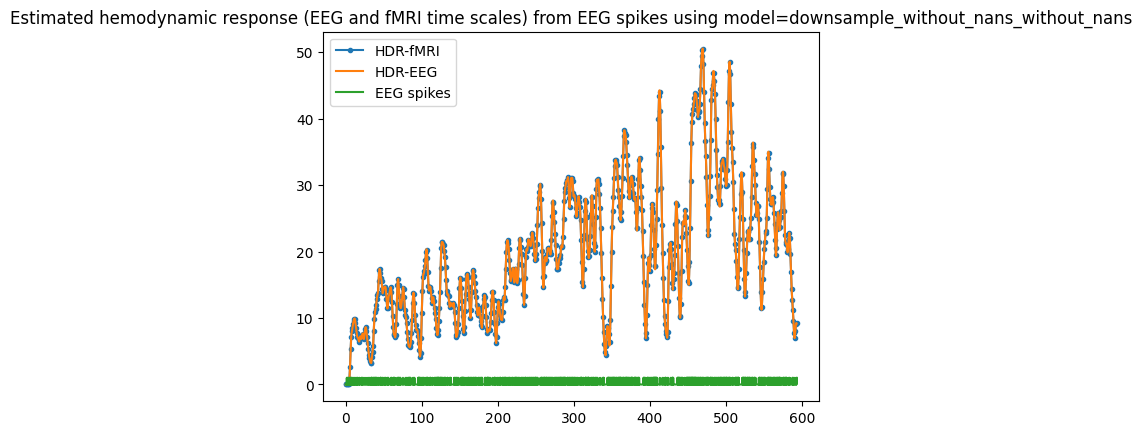

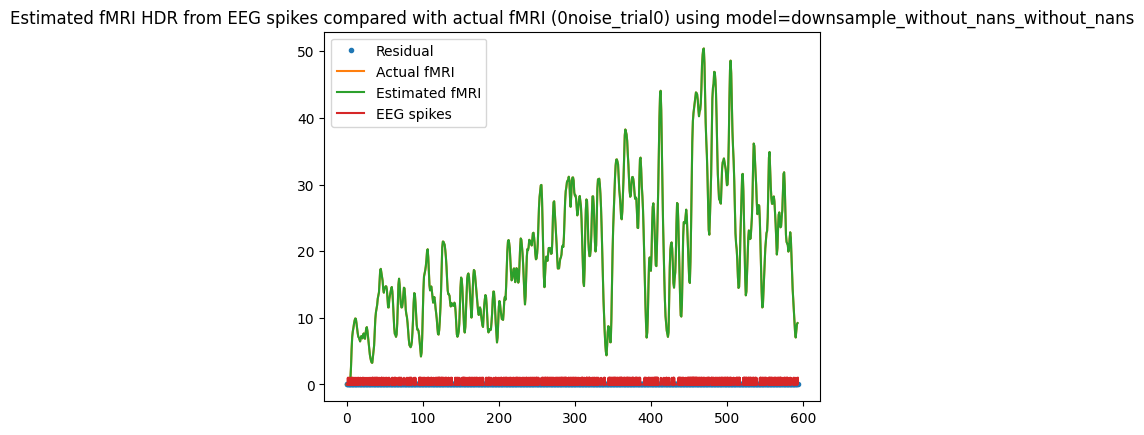

Residual Variance is 0.000000


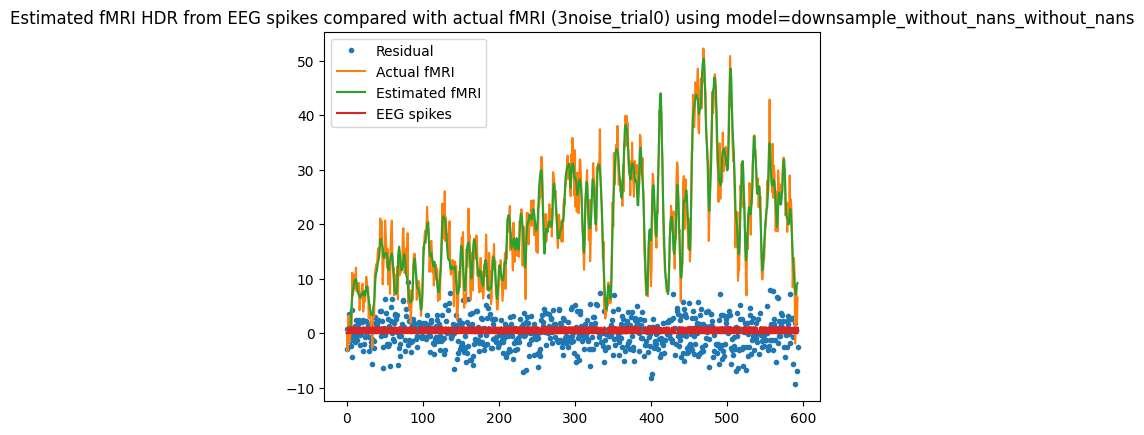

Residual Variance is 8.014992


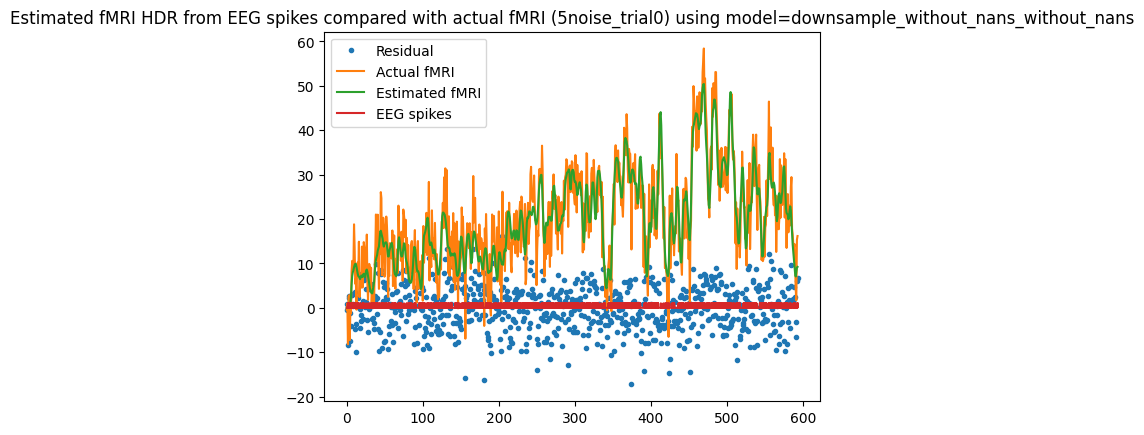

Residual Variance is 26.408215


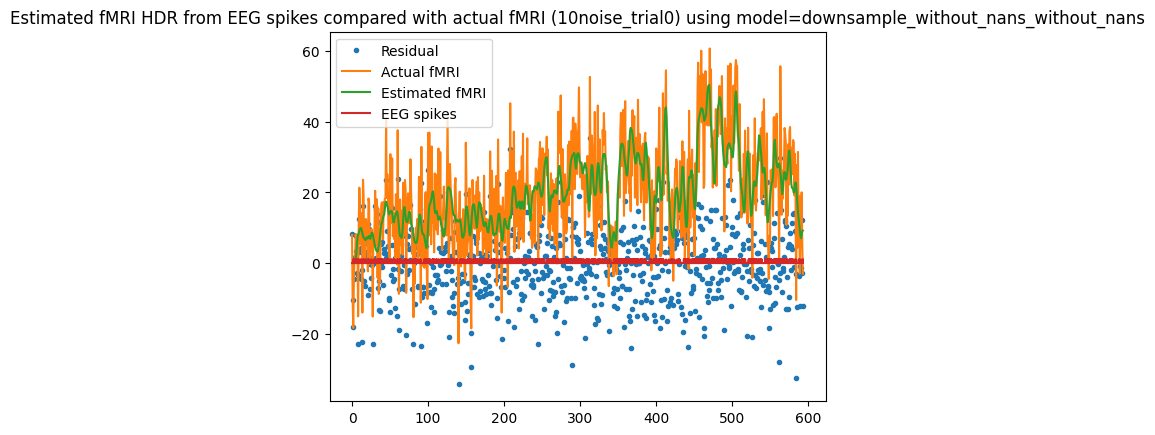

Residual Variance is 102.059395


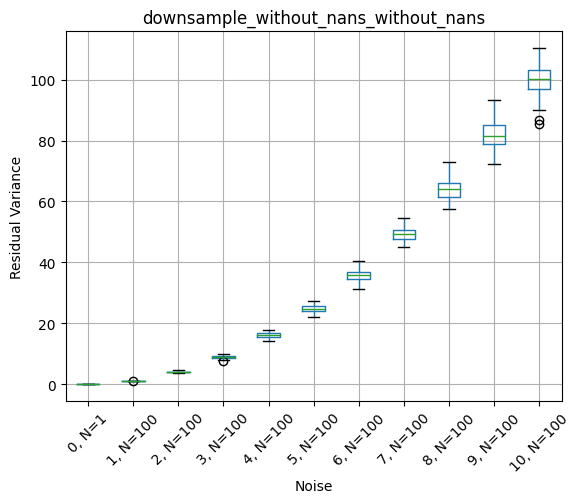

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.55, alpha=2


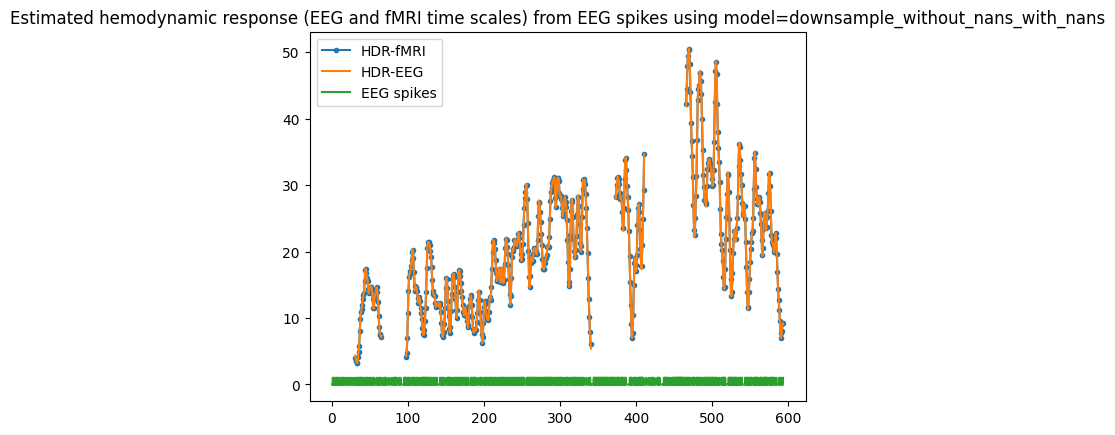

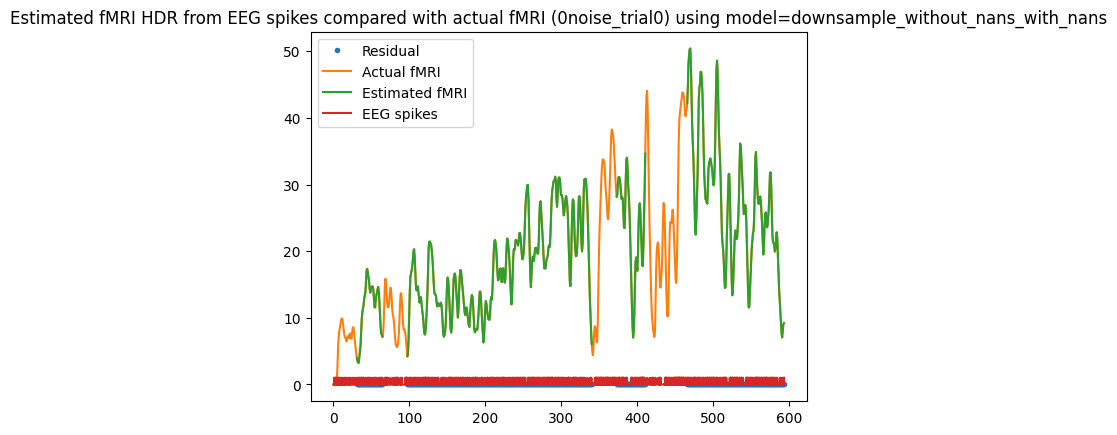

Residual Variance is 0.000000


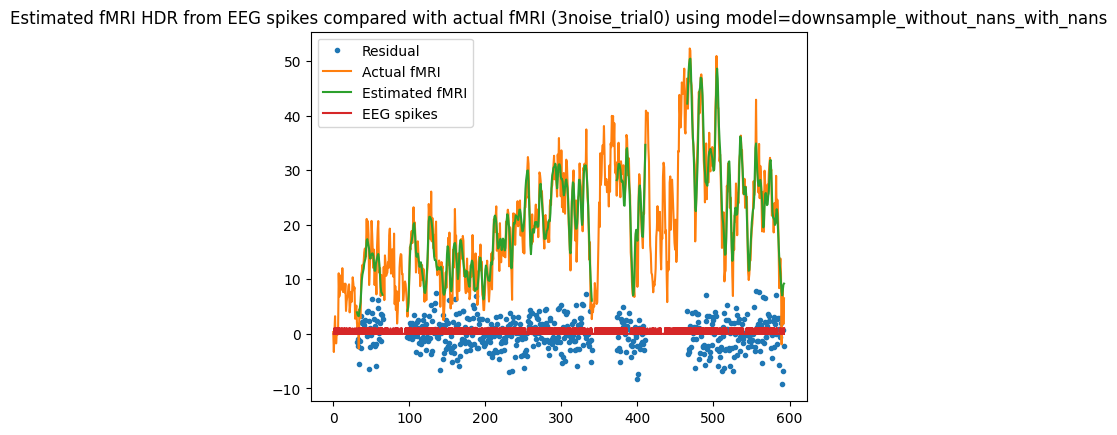

Residual Variance is 8.294200


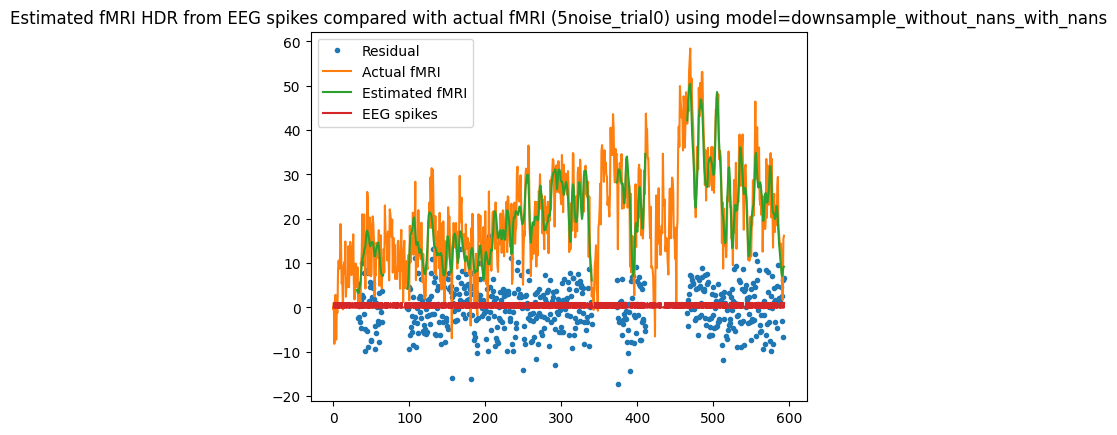

Residual Variance is 27.572490


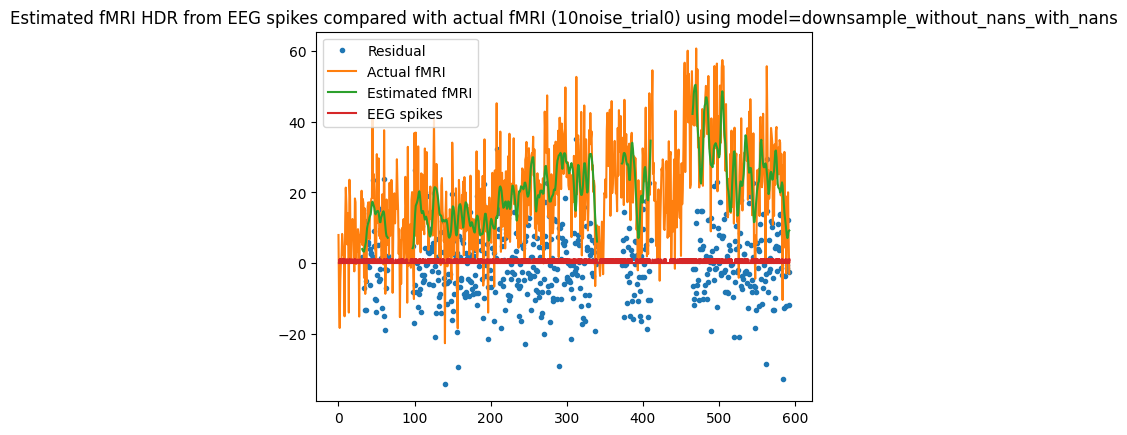

Residual Variance is 103.237695


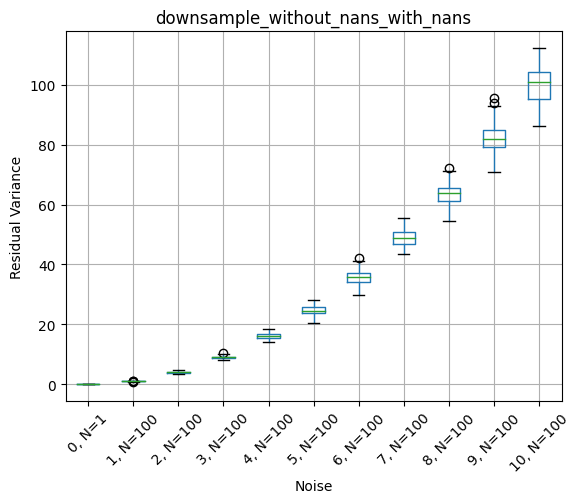

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   65.04868888053504   
1         downsample_without_nans_with_nans   58.32814735939292   
2      downsample_without_nans_without_nans   64.10866455444501   
3         downsample_without_nans_with_nans   57.54422524383737   
4      downsample_without_nans_without_nans   63.15644111639687   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   7.802547410391564   
18938  downsample_without_nans_without_nans   9.331033081058404   
18939     downsample_without_nans_with_nans     8.4869006606533   
18940  downsample_without_nans_without_nans  10.119656864896562   
18941     downsample_without_nans_with_nans   9.182905411718068   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       66.04964689138363   69.86793684652379    74.9535047555931   
1        59.1584572401485   62.30360417528532   69.87060471635179   
2       65.12356033458953    68.9189937179578   73.96219706215953   
3        58.3822633126134  61.525420464314315   69.03162685393903   
4       64.18497576219828   67.95739036121559   72.95753553574717   
...                   ...                 ...                 ...   
18937   8.550679007859056  11.040487933351036   17.22666671446684   
18938  10.091286573613445   12.77331101231834  18.581853491997773   
18939   9.225826449147807   11.67835570878028  17.971977408581825   
18940  10.872850769196887    13.5297397395099  19.426056229857146   
18941   9.912344541974571   12.32896172895066  18.727545545238904   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       80.82511861207115   94.69556784065547  ...   65.47463559109217   
1       73.37353256467395    88.8703118520392  ...  58.775781341481796   
2       79.92338986359255   93.77427943000356  ...   64.55757339387719   
3       72.61999349424292   88.12607741409106  ...  58.018148208365986   
4       79.00803148115034   92.83721305264562  ...  63.628079883563366   
...                   ...                 ...  ...                 ...   
18937  24.221202218424295   33.92358765910802  ...   8.413634655795924   
18938  25.074549946085913    35.2614784262428  ...    9.94848261840933   
18939  24.848401697995744   34.58559436331851  ...   9.074468530890114   
18940   25.83113735376953   36.05421527502746  ...  10.717175056479562   
18941   25.48624196414071  35.264304066374166  ...   9.747514998694683   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       66.94349260891822    72.0527097232789   83.16285253863818   
1      60.432550205797206   65.62419590969654   72.66963359504966   
2       66.02219444695653   71.12189336987007   82.17151962199368   
3       59.66649414580165   64.85631369512181   71.89307595902389   
4       65.08924050865903   70.17938334359032   81.16950175164348   
...                   ...                 ...                 ...   
18937  11.515969723136882  16.729556534873144  26.084442247033966   
18938  13.464385023410882  19.121347770795353   27.85762680550065   
18939  12.163480129352717  17.399367875524902  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 3.4592378485958848e-28; at
       delta   tau  alpha
11912   2.25  1.55    2.0


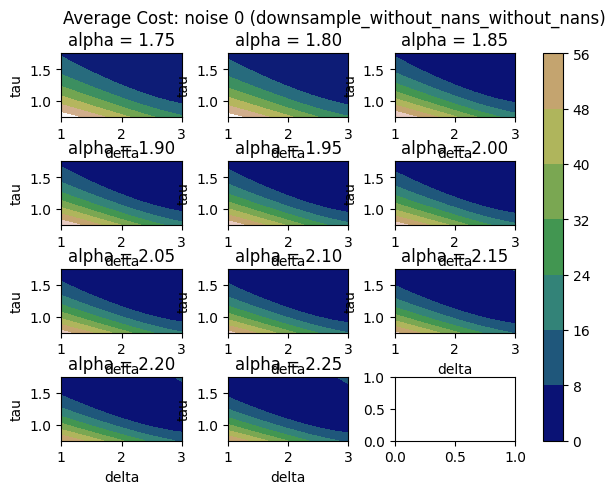

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              65.048689             
2                                              64.108665             
4                                              63.156441             
6                                              62.192541             
8                                              61.217512             
...                                                  ...             
18932                                           7.070379             
18934                                           7.804136             
18936                                           8.558458             
18938                                           9.331033             
18940                                          10.119657             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.55, Alpha target: 2


delta   tau  alpha
0   2.25  1.55    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.55, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  2.232417e-03   2.15  1.50   2.15
1      0         0  3.459238e-28   2.25  1.55   2.00
2      0         0  2.919290e-03   2.30  1.60   1.90
3      0         0  7.950314e-03   2.40  1.65   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration     cost  delta   tau  alpha
3      0         0  0.00795    2.4  1.65   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 1.60794245832106e-28; at
       delta   tau  alpha
11913   2.25  1.55    2.0


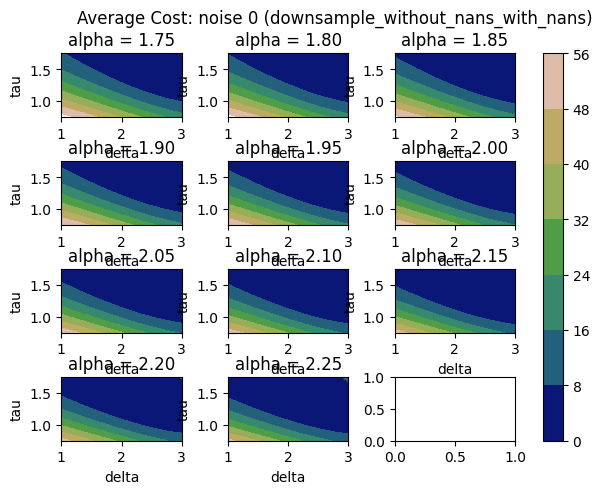

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              58.328147          
3                                              57.544225          
5                                              56.747160          
7                                              55.937324          
9                                              55.115121          
...                                                  ...          
18933                                           6.477315          
18935                                           7.131946          
18937                                           7.802547          
18939                                           8.486901          
18941                                           9.182905          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.55, Alpha target: 2


delta   tau  alpha
0   2.25  1.55    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.55, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  2.257633e-03   2.15  1.50   2.15
1      0         0  1.607942e-28   2.25  1.55   2.00
2      0         0  2.614631e-03   2.30  1.60   1.90
3      0         0  7.900430e-03   2.40  1.65   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration    cost  delta   tau  alpha
3      0         0  0.0079    2.4  1.65   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.007480235161559; at
       delta   tau  alpha
11912   2.25  1.55    2.0


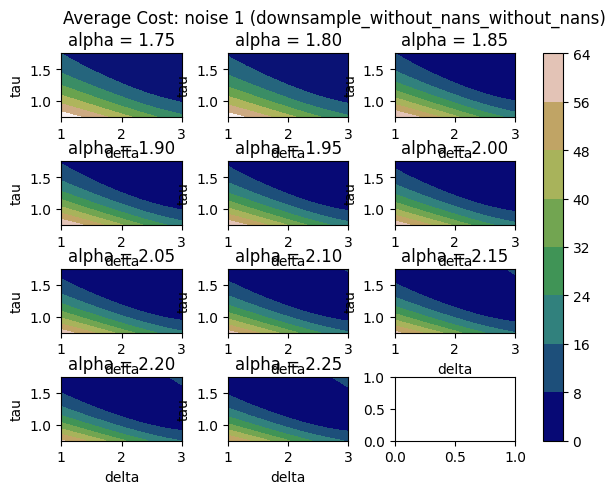

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.012850997789988; at
       delta   tau  alpha
11912   2.25  1.55    2.0


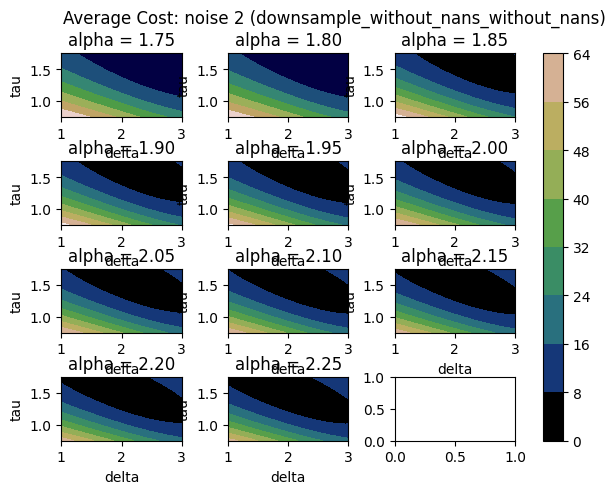

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.990711585286615; at
       delta   tau  alpha
11912   2.25  1.55    2.0


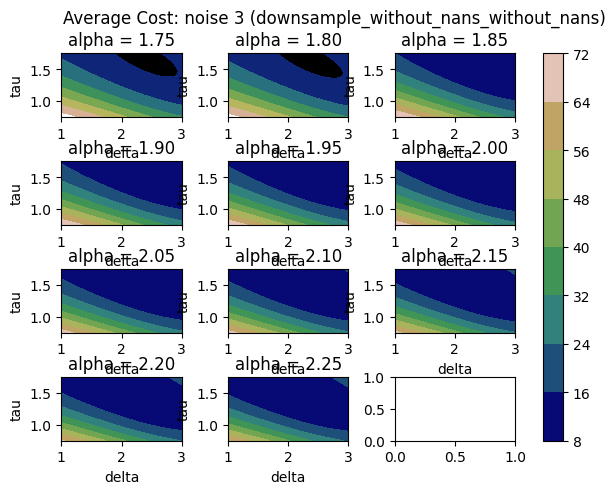

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.07723533079922; at
       delta   tau  alpha
11912   2.25  1.55    2.0


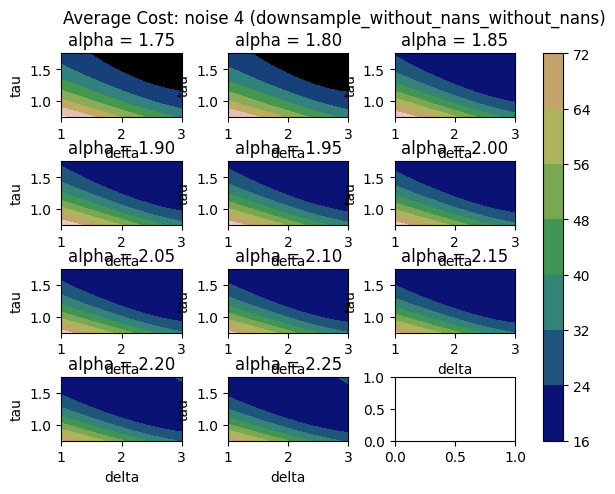

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.768918042968416; at
       delta   tau  alpha
11912   2.25  1.55    2.0


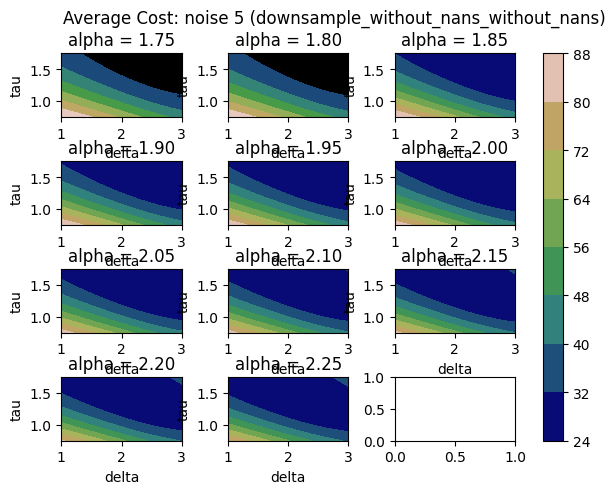

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.89803298465726; at
       delta   tau  alpha
11912   2.25  1.55    2.0


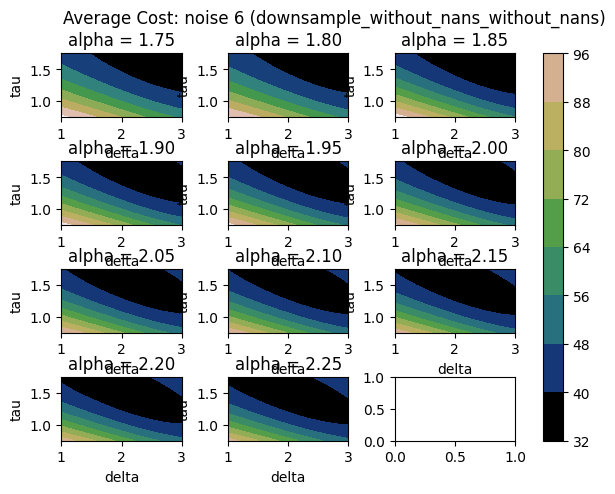

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.10685199602007; at
       delta  tau  alpha
12392    2.3  1.6    1.9


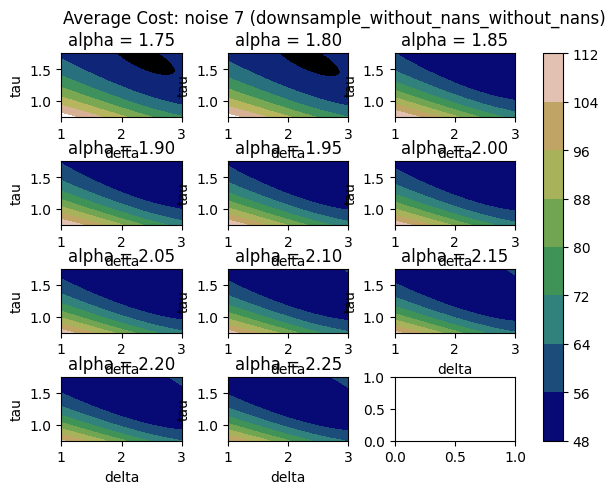

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.869552006604025; at
       delta  tau  alpha
11432    2.2  1.5    2.1


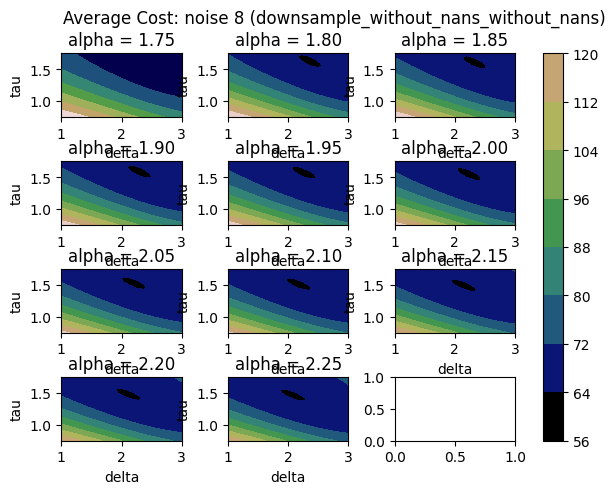

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 82.06270045969487; at
       delta   tau  alpha
11912   2.25  1.55    2.0


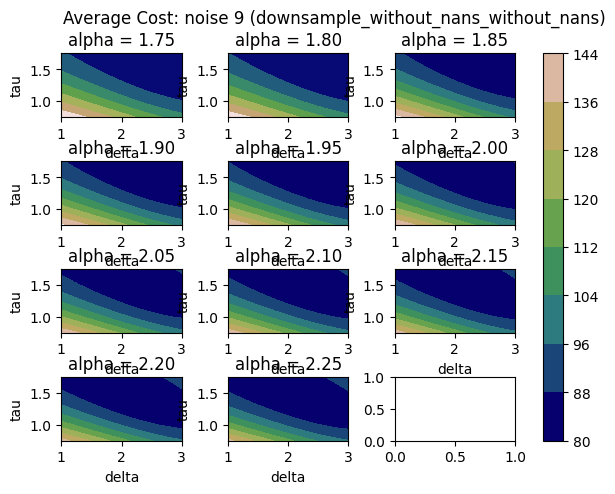

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.24426833630405; at
       delta  tau  alpha
10972   2.15  1.5   2.15


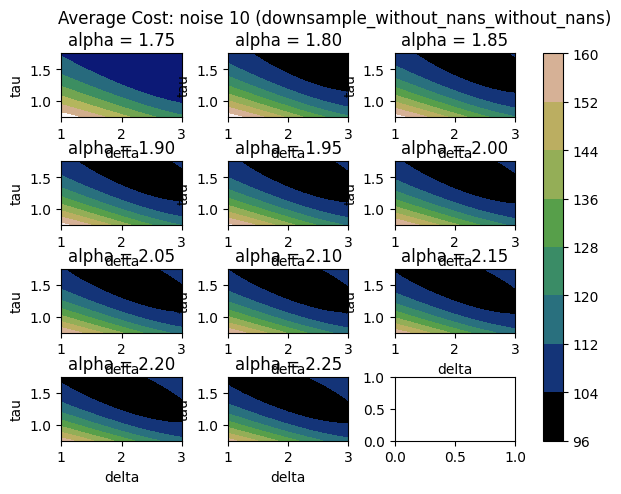

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

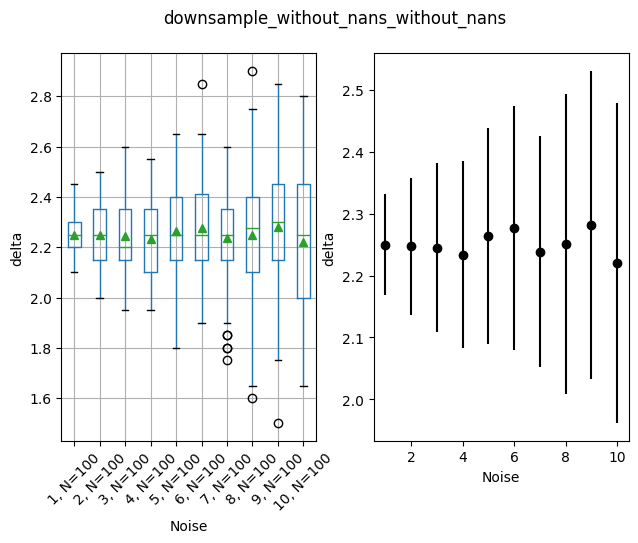

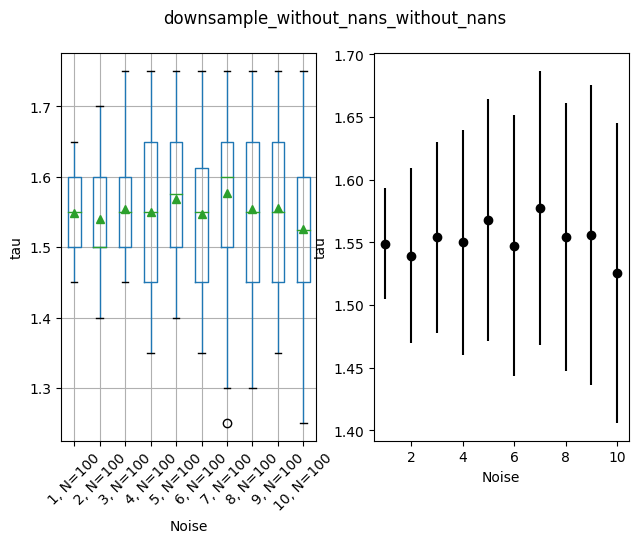

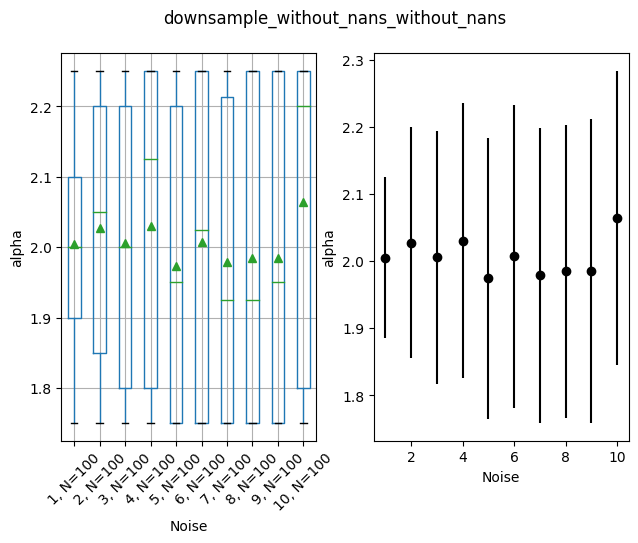

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.00568463305823; at
       delta   tau  alpha
11913   2.25  1.55    2.0


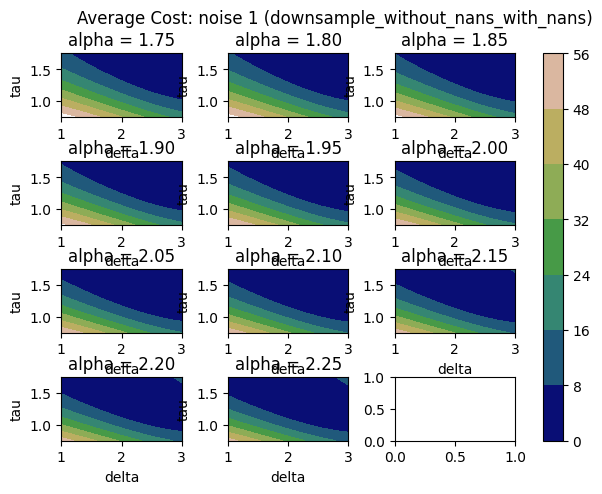

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.022972756246819; at
       delta   tau  alpha
11913   2.25  1.55    2.0


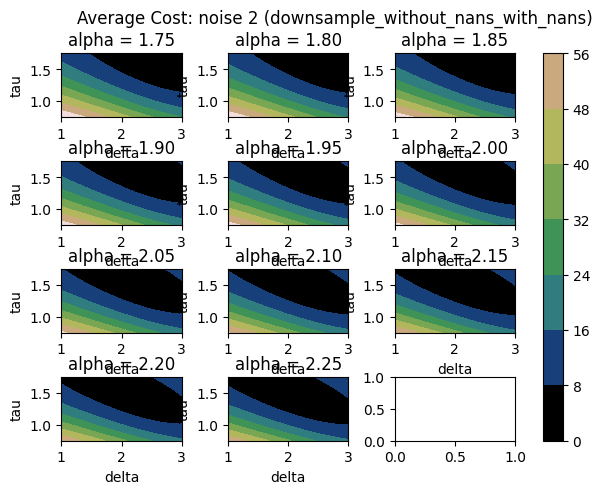

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.96483821550408; at
       delta   tau  alpha
11913   2.25  1.55    2.0


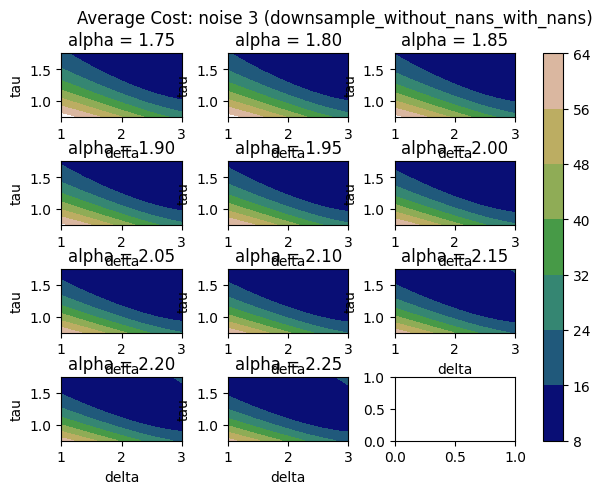

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.089845856753332; at
       delta   tau  alpha
11913   2.25  1.55    2.0


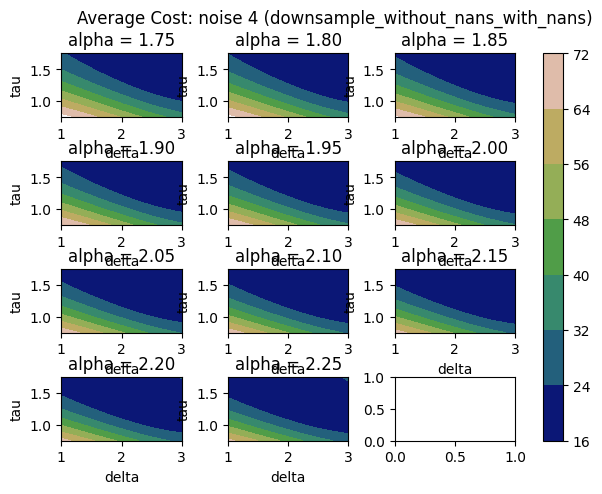

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.681209315659167; at
       delta   tau  alpha
11913   2.25  1.55    2.0


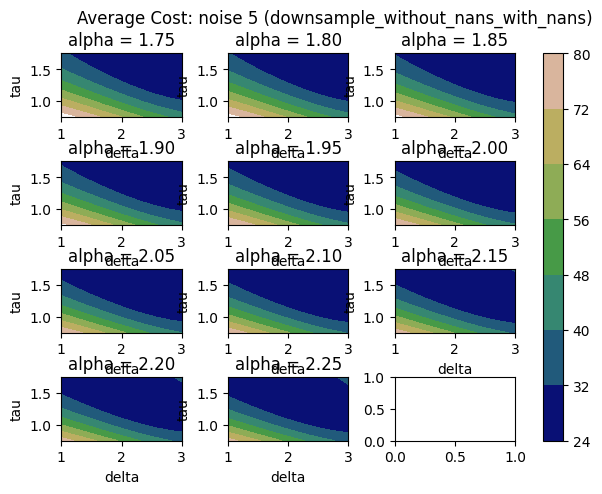

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.8026920873344; at
       delta   tau  alpha
11913   2.25  1.55    2.0


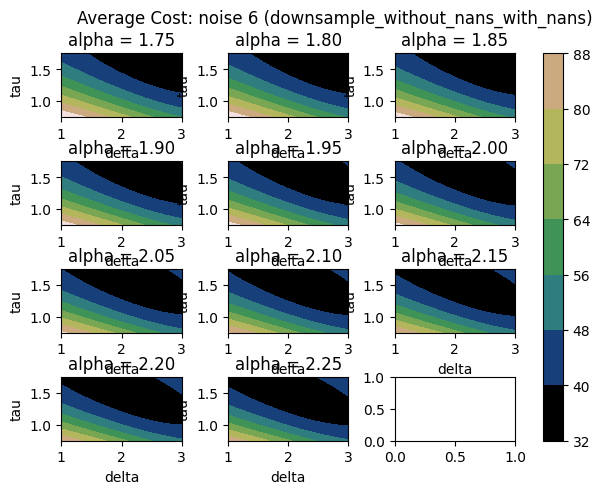

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.854097855443804; at
       delta   tau  alpha
13333    2.4  1.65   1.75


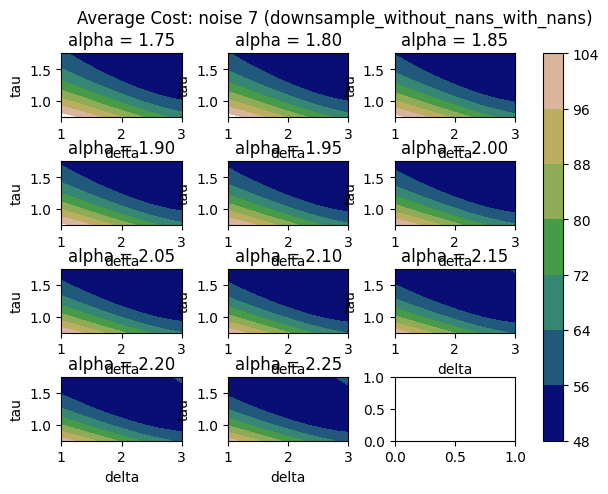

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.553911968144455; at
       delta  tau  alpha
11433    2.2  1.5    2.1


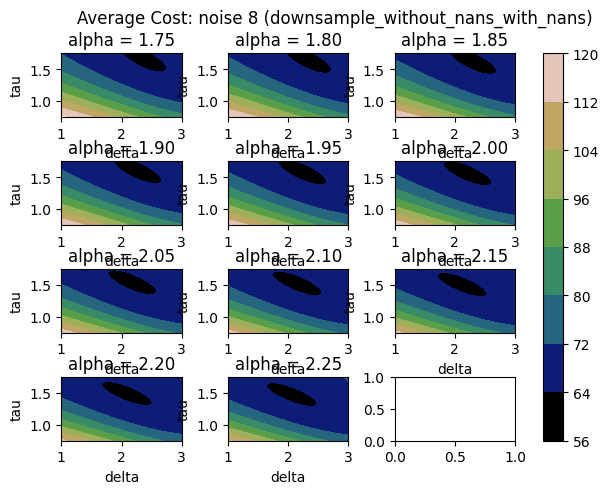

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 82.38342453256207; at
       delta   tau  alpha
11913   2.25  1.55    2.0


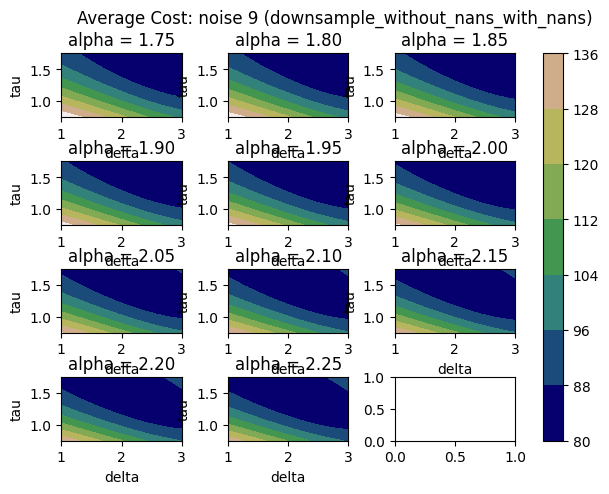

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.04244715162518; at
       delta   tau  alpha
10955   2.15  1.45   2.25


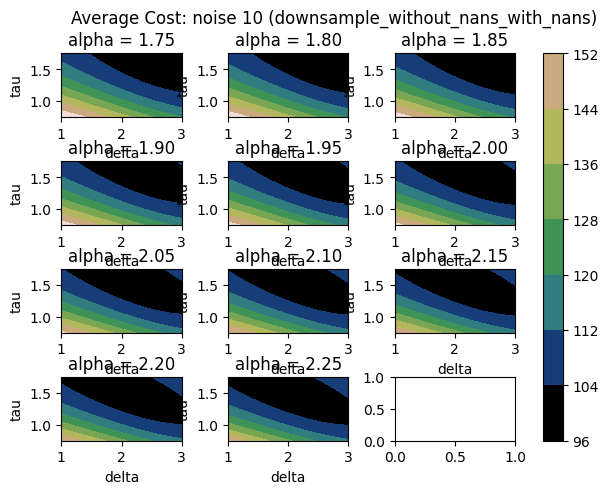

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


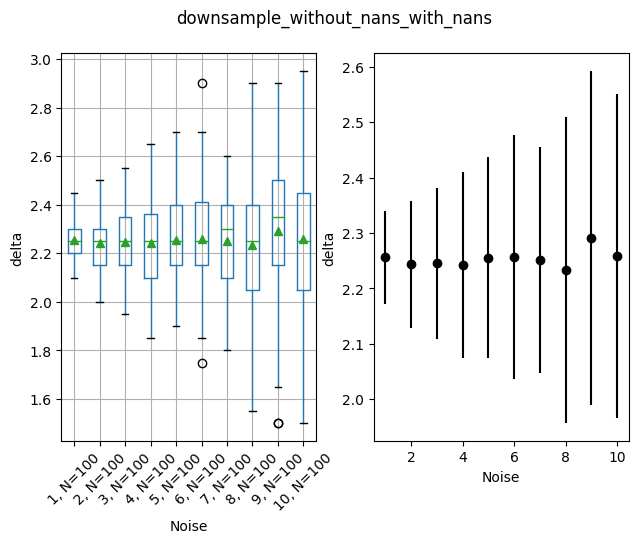

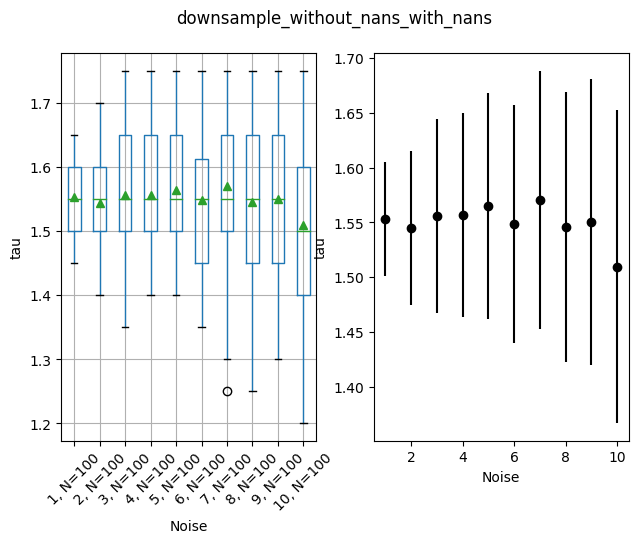

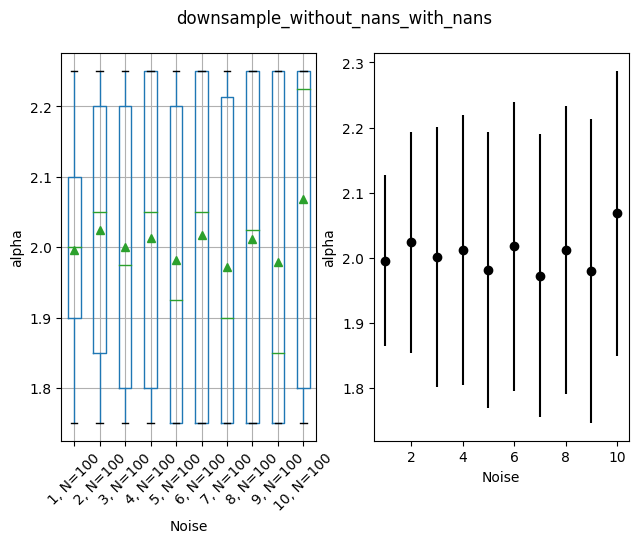

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         3    1.010745  2.0500000000000007  1.5000000000000007   
1         1        22    0.988891  2.0500000000000007  1.5000000000000007   
2         1         2    0.989780   2.100000000000001  1.4500000000000006   
3         1        20    1.005499   2.100000000000001  1.4500000000000006   
4         1        25    1.018096   2.100000000000001  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2944     10        83  102.747607  2.6500000000000012  1.5000000000000007   
2945     10        87   93.542201  2.6500000000000012  1.5500000000000007   
2946     10        22  108.828379  2.7000000000000015  1.5000000000000007   
2947     10        37   99.350606  2.7500000000000018  1.4000000000000006   
2948     10        37   99.348015  2.8000000000000016  1.4500000000000006   

                   alpha  
0                    2.2  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2944                1.75  
2945                1.75  
2946                1.75  
2947                1.85  
2948                1.75  

[2949 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  4.37  0.960377  3.0  4.0  4.0  5.00  7.0
2                      100.0  4.08  0.960640  1.0  4.0  4.0  5.00  6.0
3                      100.0  3.33  1.189644  1.0  3.0  3.0  4.00  6.0
4                      100.0  3.12  1.409062  1.0  2.0  3.0  4.00  7.0
5                      100.0  2.76  1.407914  1.0  2.0  3.0  4.00  6.0
6                      100.0  2.44  1.297394  1.0  1.0  2.0  3.25  6.0
7                      100.0  2.65  1.486471  1.0  1.0  2.5  4.00  7.0
8                      100.0  2.35  1.380784  1.0  1.0  2.0  3.00  6.0
9                      100.0  2.10  1.275250  1.0  1.0  2.0  3.00  5.0
10                     100.0  2.29  1.297200  1.0  1.0  2.0  3.00  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
1083      3        83    8.980551   2.300000000000001  1.7500000000000009   
1084      3        98    9.749268   2.300000000000001  1.7500000000000009   
1366      4        14   16.729334   2.250000000000001  1.7500000000000009   
1367      4         5   17.064183   2.250000000000001  1.7500000000000009   
1432      4        24   16.930806  2.3500000000000014  1.7500000000000009   
...     ...       ...         ...                 ...                 ...   
2815     10         8  103.219359  2.1500000000000012  1.7500000000000009   
2838     10        80   95.579556   2.200000000000001  1.7500000000000009   
2855     10        20  101.583434   2.250000000000001  1.7500000000000009   
2856     10         2   93.992637   2.250000000000001  1.7500000000000009   
2914     10         3  105.602572   2.450000000000001  1.7500000000000009   

     alpha  
1083  1.75  
1084  1.75  
1366  1.75  
1367  1.85  
1432  1.75  
...    ...  
2815  1.85  
2838  1.75  
2855  1.75  
2856   1.8  
2914  1.75  

[70 rows x 6 columns]

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
387       1         2    0.987566  2.4000000000000012  1.6500000000000008   
388       1         5    1.087694  2.4000000000000012  1.6500000000000008   
389       1        11    1.031536  2.4000000000000012  1.6500000000000008   
390       1        15    1.023239  2.4000000000000012  1.6500000000000008   
391       1        19    1.010146  2.4000000000000012  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
2942     10         9  104.487270  2.6000000000000014  1.6500000000000008   
2944     10        83  102.747607  2.6500000000000012  1.5000000000000007   
2945     10        87   93.542201  2.6500000000000012  1.5500000000000007   
2946     10        22  108.828379  2.7000000000000015  1.5000000000000007   
2948     10        37   99.348015  2.8000000000000016  1.4500000000000006   

     alpha  
387   1.75  
388   1.75  
389   1.75  
390   1.75  
391   1.75  
...    ...  
2942  1.75  
2944  1.75  
2945  1.75  
2946  1.75  
2948  1.75  

[393 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        46      2  2.4000000000000012   34    46      1  1.6500000000000008   
10       28     12  2.5000000000000013    6    28      7  1.6000000000000008   
2        37      6  2.4000000000000012   21    37      3  1.6500000000000008   
3        34      5  2.3500000000000014   12    34      5  1.6500000000000008   
4        36      7  2.4000000000000012   10    36      5  1.6500000000000008   
5        38     10   2.300000000000001    6    38      6  1.7000000000000008   
6        38     11   2.450000000000001    7    38      6  1.6500000000000008   
7        48      9  2.3500000000000014   10    48      5  1.6500000000000008   
8        42     15   2.450000000000001    6    42      7  1.6000000000000008   
9        46     14  2.3500000000000014    6    46      7  1.6500000000000008   

            
      freq  
noise       
1       46  
10       8  
2       30  
3       18  
4       16  
5       11  
6       11  
7       19  
8       11  
9       10

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1         2    0.989780   2.100000000000001  1.4500000000000006   
3         1        20    1.005499   2.100000000000001  1.4500000000000006   
4         1        25    1.018096   2.100000000000001  1.4500000000000006   
5         1        31    1.099006   2.100000000000001  1.4500000000000006   
6         1        32    1.064265   2.100000000000001  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2904     10        92   99.757609   2.450000000000001  1.3500000000000005   
2915     10        36   95.895453  2.5000000000000013  1.3000000000000005   
2919     10        45   94.439916  2.5000000000000013  1.4500000000000006   
2931     10        89  109.775451  2.5500000000000016  1.3500000000000005   
2938     10        50  100.622223  2.6000000000000014  1.4000000000000006   

                   alpha  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
...                  ...  
2904  2.2500000000000004  
2915  2.2500000000000004  
2919  2.2500000000000004  
2931  2.2500000000000004  
2938  2.2500000000000004  

[470 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        52      2   2.100000000000001   27    52      1  1.4500000000000006   
10       64     19  2.1500000000000012    7    64      8  1.4500000000000006   
2        49      7  2.1500000000000012   22    49      3  1.4500000000000006   
3        35      8   2.100000000000001   10    35      3  1.4500000000000006   
4        44      8  2.1500000000000012   12    44      5  1.4500000000000006   
5        39     11  2.1500000000000012   10    39      5  1.4500000000000006   
6        43     13   2.200000000000001    9    43      6  1.4500000000000006   
7        45     14  2.1500000000000012    8    45      7  1.5000000000000007   
8        46     15  2.0500000000000007    6    46      8  1.4500000000000006   
9        53     16   2.250000000000001    9    53      9  1.4500000000000006   

            
      freq  
noise       
1       52  
10      15  
2       39  
3       22  
4       23  
5       14  
6       16  
7       17  
8       14  
9       18

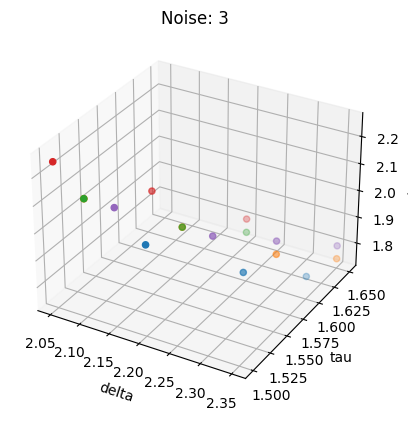

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

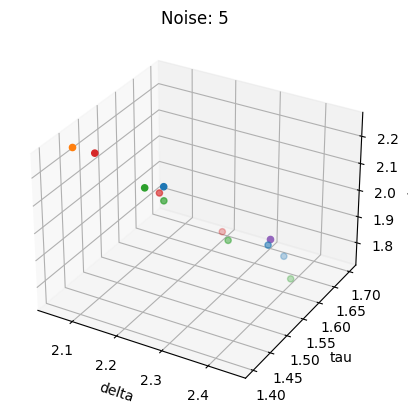

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

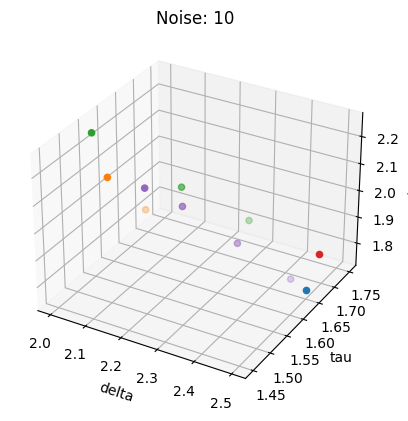

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        61    0.928143   2.000000000000001  1.5000000000000007   
1         1         1    0.966327   2.100000000000001  1.4500000000000006   
2         1         2    0.989173   2.100000000000001  1.4500000000000006   
3         1         5    1.099650   2.100000000000001  1.4500000000000006   
4         1        22    0.983743   2.100000000000001  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2738     10        37   99.759195  2.8500000000000014  1.3500000000000005   
2739     10        50  103.030290  2.8500000000000014  1.3500000000000005   
2740     10        22  105.956710  2.8500000000000014  1.4500000000000006   
2741     10        18   94.317225   2.950000000000002  1.4500000000000006   
2742     10        12  101.437400   2.950000000000002  1.4500000000000006   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2738                 1.8  
2739  2.2500000000000004  
2740                1.75  
2741                1.75  
2742                 1.8  

[2743 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  4.29  0.728843  3.0  4.0  4.0  5.0  7.0
2                      100.0  3.64  1.039814  1.0  3.0  4.0  4.0  6.0
3                      100.0  3.14  1.214558  1.0  2.0  3.0  4.0  5.0
4                      100.0  2.89  1.369915  1.0  2.0  3.0  4.0  6.0
5                      100.0  2.54  1.466253  1.0  1.0  2.0  4.0  6.0
6                      100.0  2.33  1.247664  1.0  1.0  2.0  3.0  5.0
7                      100.0  2.30  1.534124  1.0  1.0  2.0  3.0  7.0
8                      100.0  2.31  1.292519  1.0  1.0  2.0  3.0  6.0
9                      100.0  1.92  1.194939  1.0  1.0  1.0  3.0  6.0
10                     100.0  2.07  1.156929  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost              delta                 tau  \
1029      3        83    8.586688  2.300000000000001  1.7500000000000009   
1030      3        98    9.912032  2.300000000000001  1.7500000000000009   
1240      4         4   15.700834  2.200000000000001  1.7500000000000009   
1241      4        24   16.435491  2.200000000000001  1.7500000000000009   
1277      4        98   17.225372  2.250000000000001  1.7500000000000009   
...     ...       ...         ...                ...                 ...   
2627     10        26   99.331300  2.200000000000001  1.7500000000000009   
2628     10        72   89.640128  2.200000000000001  1.7500000000000009   
2644     10        43  109.515496  2.250000000000001  1.7500000000000009   
2645     10        60  105.816131  2.250000000000001  1.7500000000000009   
2657     10        72   89.639137  2.300000000000001  1.7500000000000009   

                   alpha  
1029                1.75  
1030                1.75  
1240                 1.8  
1241                1.85  
1277                 1.8  
...                  ...  
2627                1.85  
2628  1.9000000000000001  
2644                1.75  
2645                1.75  
2657                1.85  

[91 rows x 6 columns]

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
369       1        57    0.949902  2.3500000000000014  1.7000000000000008   
383       1         0    0.925869  2.4000000000000012  1.6500000000000008   
384       1         1    0.980821  2.4000000000000012  1.6500000000000008   
385       1         2    0.972210  2.4000000000000012  1.6500000000000008   
386       1         5    1.090438  2.4000000000000012  1.6500000000000008   
...     ...       ...         ...                 ...                 ...   
2727     10        84  108.301199  2.6500000000000012  1.4500000000000006   
2729     10         9  105.071098  2.6500000000000012  1.6500000000000008   
2734     10        82  103.743641  2.7500000000000018  1.4500000000000006   
2740     10        22  105.956710  2.8500000000000014  1.4500000000000006   
2741     10        18   94.317225   2.950000000000002  1.4500000000000006   

     alpha  
369   1.75  
383   1.75  
384   1.75  
385   1.75  
386   1.75  
...    ...  
2727  1.75  
2729  1.75  
2734  1.75  
2740  1.75  
2741  1.75  

[379 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        41      3  2.4000000000000012   31    41      2  1.6500000000000008   
10       29     14  2.5500000000000016    5    29      7  1.6500000000000008   
2        28      6  2.4000000000000012    9    28      3  1.6500000000000008   
3        30      7  2.4000000000000012   11    30      4  1.6500000000000008   
4        33      7   2.450000000000001    9    33      6  1.6500000000000008   
5        45     10   2.300000000000001    7    45      5  1.7000000000000008   
6        39     13  2.5000000000000013    7    39      7  1.6000000000000008   
7        47     12  2.5000000000000013   10    47      6  1.6500000000000008   
8        38     13  2.3500000000000014    6    38      7  1.7000000000000008   
9        49     15  2.4000000000000012    7    49      9  1.7500000000000009   

            
      freq  
noise       
1       40  
10       7  
2       18  
3       15  
4       12  
5       14  
6       11  
7       15  
8        9  
9       11

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        61    0.928143   2.000000000000001  1.5000000000000007   
1         1         1    0.966327   2.100000000000001  1.4500000000000006   
2         1         2    0.989173   2.100000000000001  1.4500000000000006   
3         1         5    1.099650   2.100000000000001  1.4500000000000006   
4         1        22    0.983743   2.100000000000001  1.4500000000000006   
...     ...       ...         ...                 ...                 ...   
2726     10        32  100.020986  2.6500000000000012  1.2000000000000004   
2731     10        32  100.027566  2.7500000000000018  1.1500000000000004   
2733     10        98   89.148062  2.7500000000000018  1.3000000000000005   
2737     10        98   89.152206  2.8500000000000014  1.2500000000000004   
2739     10        50  103.030290  2.8500000000000014  1.3500000000000005   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2726  2.2500000000000004  
2731  2.2500000000000004  
2733  2.2500000000000004  
2737  2.2500000000000004  
2739  2.2500000000000004  

[473 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        46      3   2.100000000000001   23    46      2  1.4500000000000006   
10       66     23  2.0500000000000007    7    66     12  1.4000000000000006   
2        47      7   2.100000000000001   15    47      3  1.4500000000000006   
3        42      8  2.0500000000000007   12    42      5  1.4500000000000006   
4        50     11   2.100000000000001   10    50      7  1.4500000000000006   
5        32      9  2.1500000000000012   10    32      5  1.4500000000000006   
6        56     14   2.200000000000001    8    56      7  1.4500000000000006   
7        35     14   2.100000000000001    5    35      9  1.4500000000000006   
8        47     19  2.0500000000000007    5    47      8  1.4500000000000006   
9        52     23  2.4000000000000012    5    52      9  1.4500000000000006   

            
      freq  
noise       
1       45  
10      13  
2       31  
3       20  
4       17  
5       11  
6       16  
7        9  
8       16  
9       10

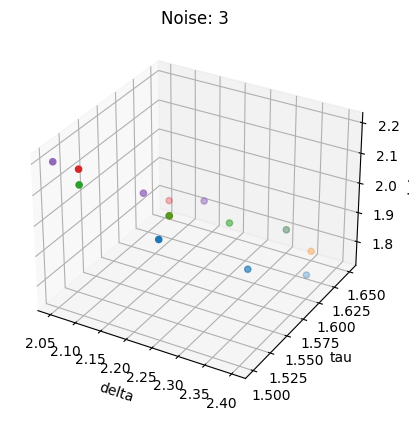

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

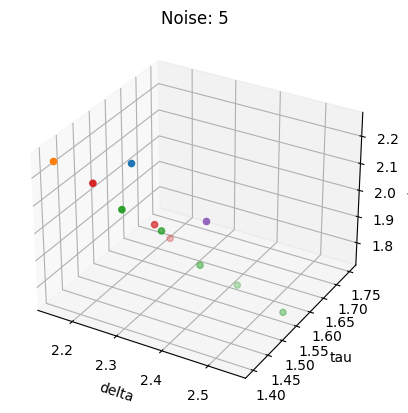

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

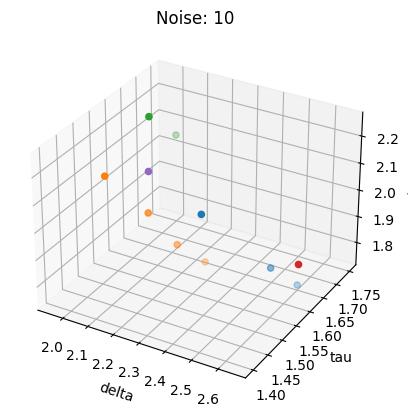

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()